In [1]:
from OfflineEvaluator import OfflineEvaluator
from Preprocessor import Preprocessor
import utils
from UserProfiler import UserProfiler

import pickle
import logging
import operator
import sys
import os
from collections import Counter
import itertools
from itertools import combinations
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import spacy
import re
import networkx as nx
import math

In [2]:
dbnum_lookup = ##{..:..} # a dictionary look-up for course number to course name
dbnums = #[..] # please fill your course number in the list

# Read in offline evaluation results

In [3]:
results = {}

In [4]:
for dbnum in dbnums:
    results[dbnum] = {}
    os.chdir('results/db%d'%dbnum)
    for met in ['RND', 'PPL', 'SCB']:
        with open('%d-%s-results_eval1.pickle'%(dbnum,met),'rb') as handle:
            res = pickle.load(handle)
            results[dbnum][met] = res
    for met in ['csclrec', 'coppr', 'pure_ppr', 'kcb', 'wmf']:
        with open('%d-%s-eval1_cv.pickle'%(dbnum,met),'rb') as handle:
            res = pickle.load(handle)
            results[dbnum][met] = res
    os.chdir('../..')

In [5]:
dfs_res = []
for dbnum in dbnums:
    lst = []
    for met,res in results[dbnum].items():
        for wk,res_all_user in res.items():
            for usr, res_usr in res_all_user[0].items():
                _, precision, recall, miuf, semd, sd ,mr = res_usr
                lst.append([met, wk,usr,precision, recall, miuf, semd, sd ,mr])
    df_res = pd.DataFrame(lst, columns=['method','week','user','p@10','r@10','miuf','ild','#adjacent posts','max possible recall'])
    df_res['course'] = dbnum
    dfs_res.append(df_res)
df_res = pd.concat(dfs_res)

In [6]:
df_res['method'] = df_res['method'].replace({'ucf':'UCF','wmf':'MCF','kcb':'KCB',
                          'csclrec':'CSCLRec','coppr':'CoPPR','pure_ppr':'PPR'})
df_res['course'] = df_res['course'].replace(dbnum_lookup)

In [7]:
df_res.head()

,method,week,user,p@10,r@10,miuf,ild,#adjacent posts,max possible recall,course
0,RND,2,1793,0.1,0.030303,0.782590,0.392777,2.0,0.303030,LA
1,RND,2,321,0.0,0.000000,1.815643,0.430576,0.0,1.000000,LA
2,RND,2,1540,0.8,0.032129,1.271950,0.471236,1.0,0.040161,LA
3,RND,2,391,0.6,0.033333,0.956656,0.284436,0.0,0.055556,LA
4,RND,2,594,0.6,0.075949,1.313131,0.611189,1.0,0.126582,LA


## Plotting

In [8]:
current_palette = sns.color_palette("deep") 

In [9]:
def plot_per_course(dbnum, df_res):
    df_res_c = df_res.loc[df_res.course==dbnum]
    sns.set(style="white", palette="deep", color_codes=True)
    # Set up the matplotlib figure
    f, axes = plt.subplots(2, 2, figsize=(20, 15))
    sns.despine(left=True)
    g1 = sns.lineplot(data=df_res_c, x='week', y='p@10', hue='method', linewidth=5, ci=None, ax=axes[0,0])
    g2 = sns.lineplot(data=df_res_c, x='week', y='r@10', hue='method', ci=None, linewidth=5, ax=axes[0,1])
    g3 = sns.lineplot(data=df_res_c, x='week', y='ild', hue='method', ci=None, linewidth=5, ax=axes[1,0])
    g4 = sns.lineplot(data=df_res_c, x='week', y='miuf', hue='method',ci=None,  linewidth=5, ax=axes[1,1])
    g1.set_xlabel('Week', fontsize=20)
    g1.set_ylabel('', fontsize=0)
    g2.set_xlabel('Week', fontsize=20)
    g2.set_ylabel('', fontsize=0)
    g3.set_xlabel('Week', fontsize=20)
    g3.set_ylabel('', fontsize=0)
    g4.set_xlabel('Week', fontsize=20)
    g4.set_ylabel('', fontsize=0)
    
    x = df_res_c.week.unique()
    xint = range(min(x), math.ceil(max(x))+1)    
    for ax in [g1,g2,g3,g4]:
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
        ax.set_xticks(xint)
        ax.lines[0].set_linestyle("--")
        ax.lines[1].set_linestyle("--")
        ax.lines[2].set_linestyle("--")
        ax.lines[3].set_linestyle("--")
    
    f.tight_layout(pad=10.0)
    f.subplots_adjust(top=0.90)

    g1.set_title('Precision@10', fontsize=25)
    g2.set_title('Recall@10', fontsize=25)
    g3.set_title('ILD', fontsize=25)
    g4.set_title('MIUF', fontsize=25)


    g1.get_legend().remove()
    g2.get_legend().remove()
    g3.get_legend().remove()    
    handles, labels = g4.get_legend_handles_labels()
    leg = g4.legend(handles=handles[1:], labels=labels[1:],prop={"size":30},ncol=4)
    leg_lines = leg.get_lines()
    leg_lines[0].set_linestyle("--")
    leg_lines[1].set_linestyle("--")
    leg_lines[2].set_linestyle("--")
    leg_lines[3].set_linestyle("--")
    for legobj in leg.legendHandles:
        legobj.set_linewidth(8.0)
    g4.get_legend().set_bbox_to_anchor((1.13,.8))

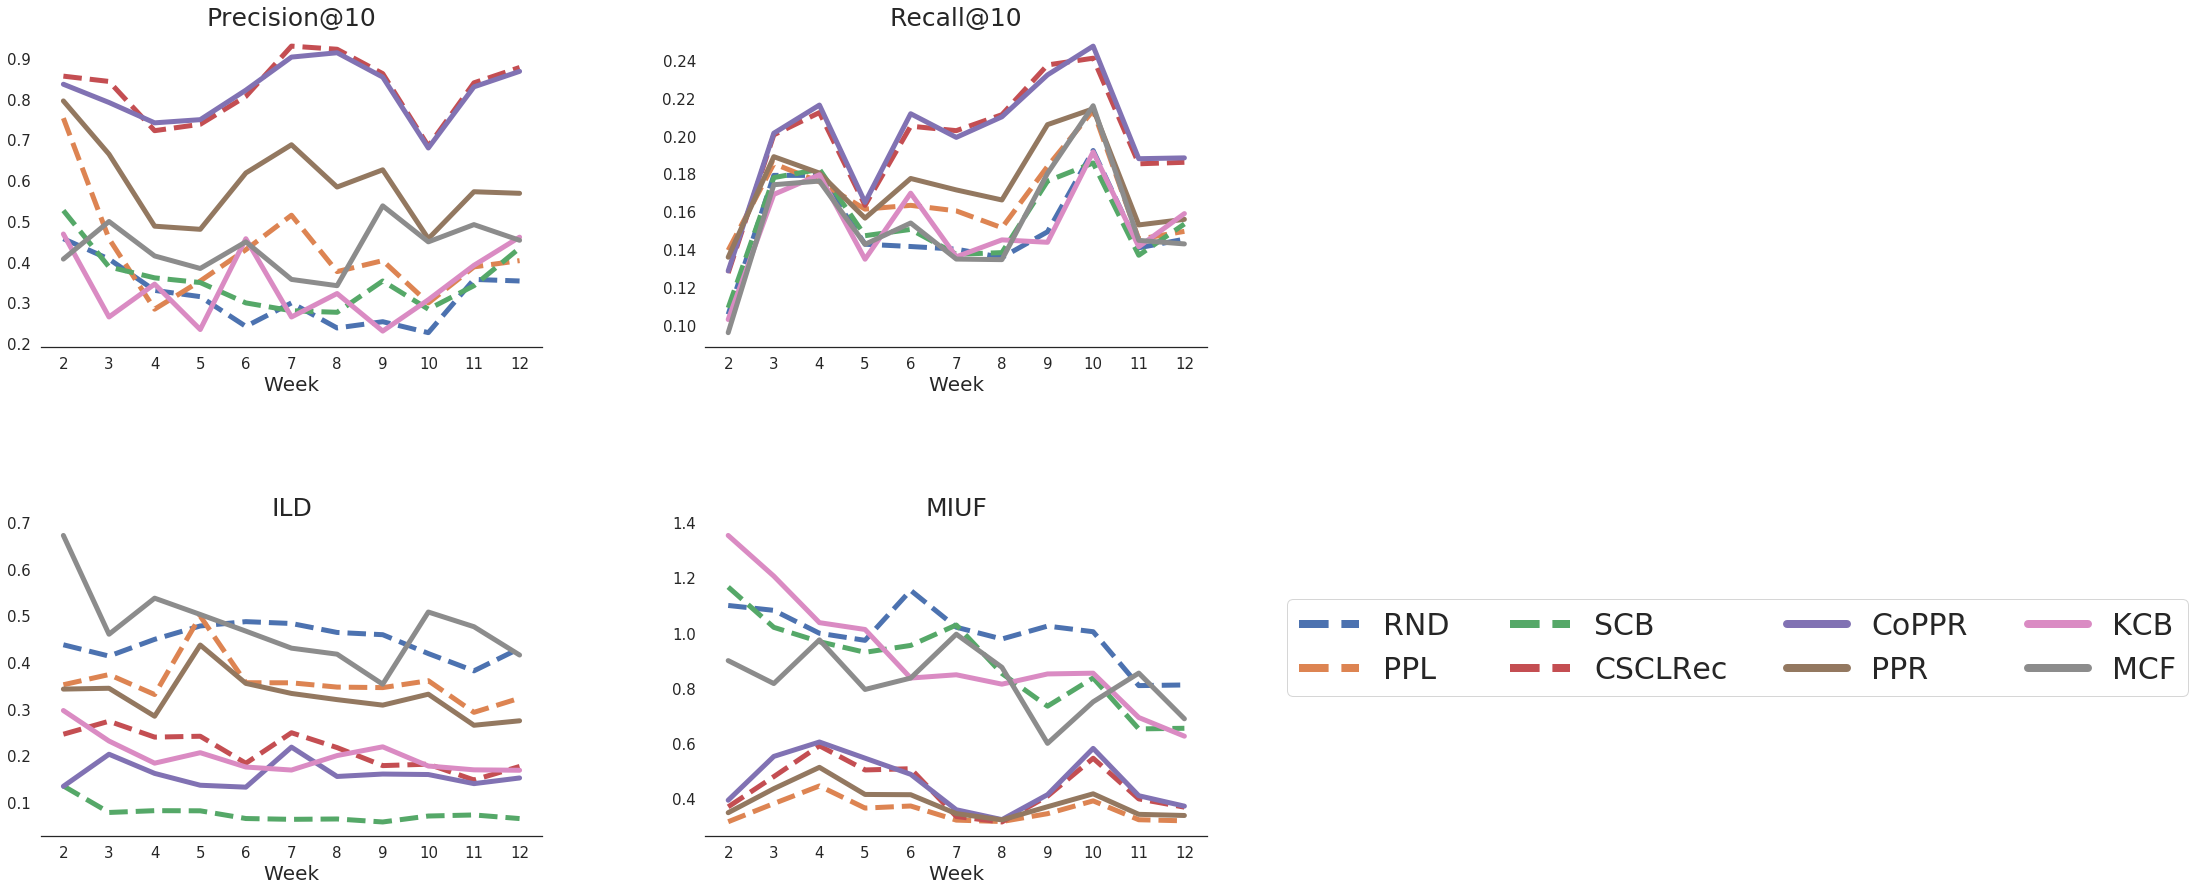

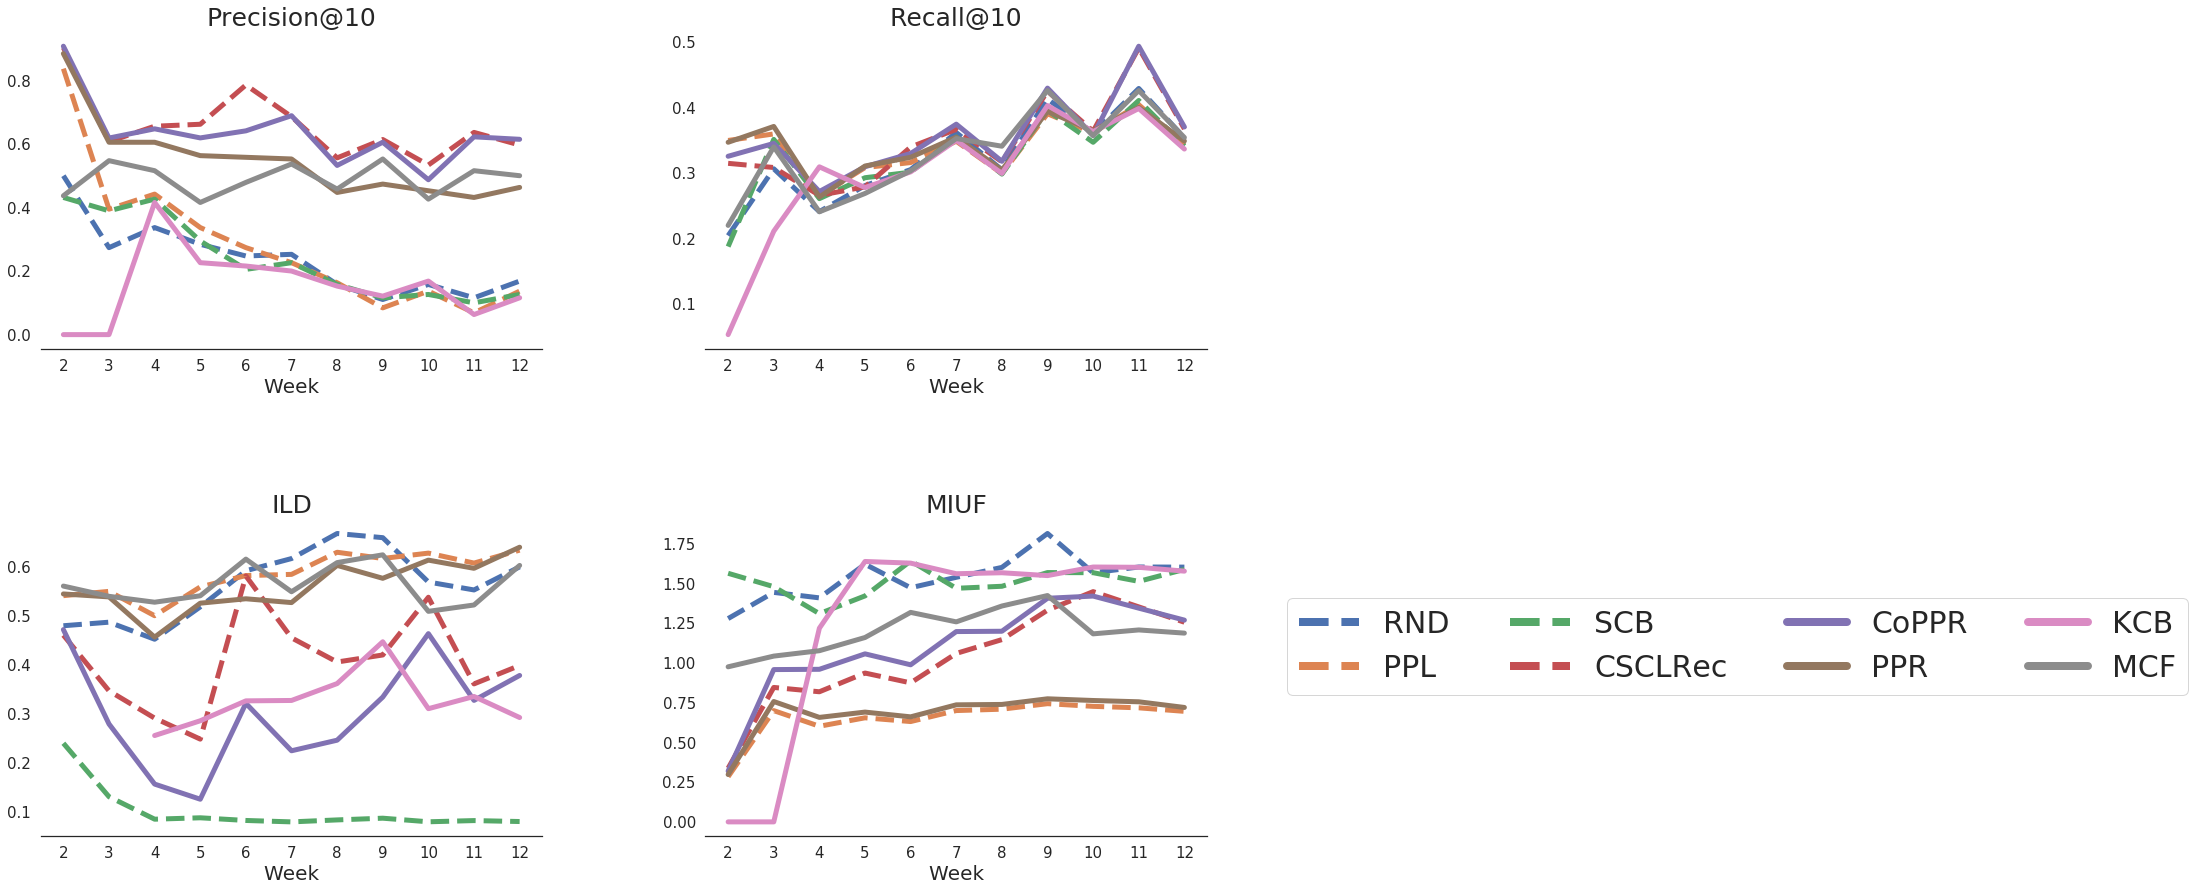

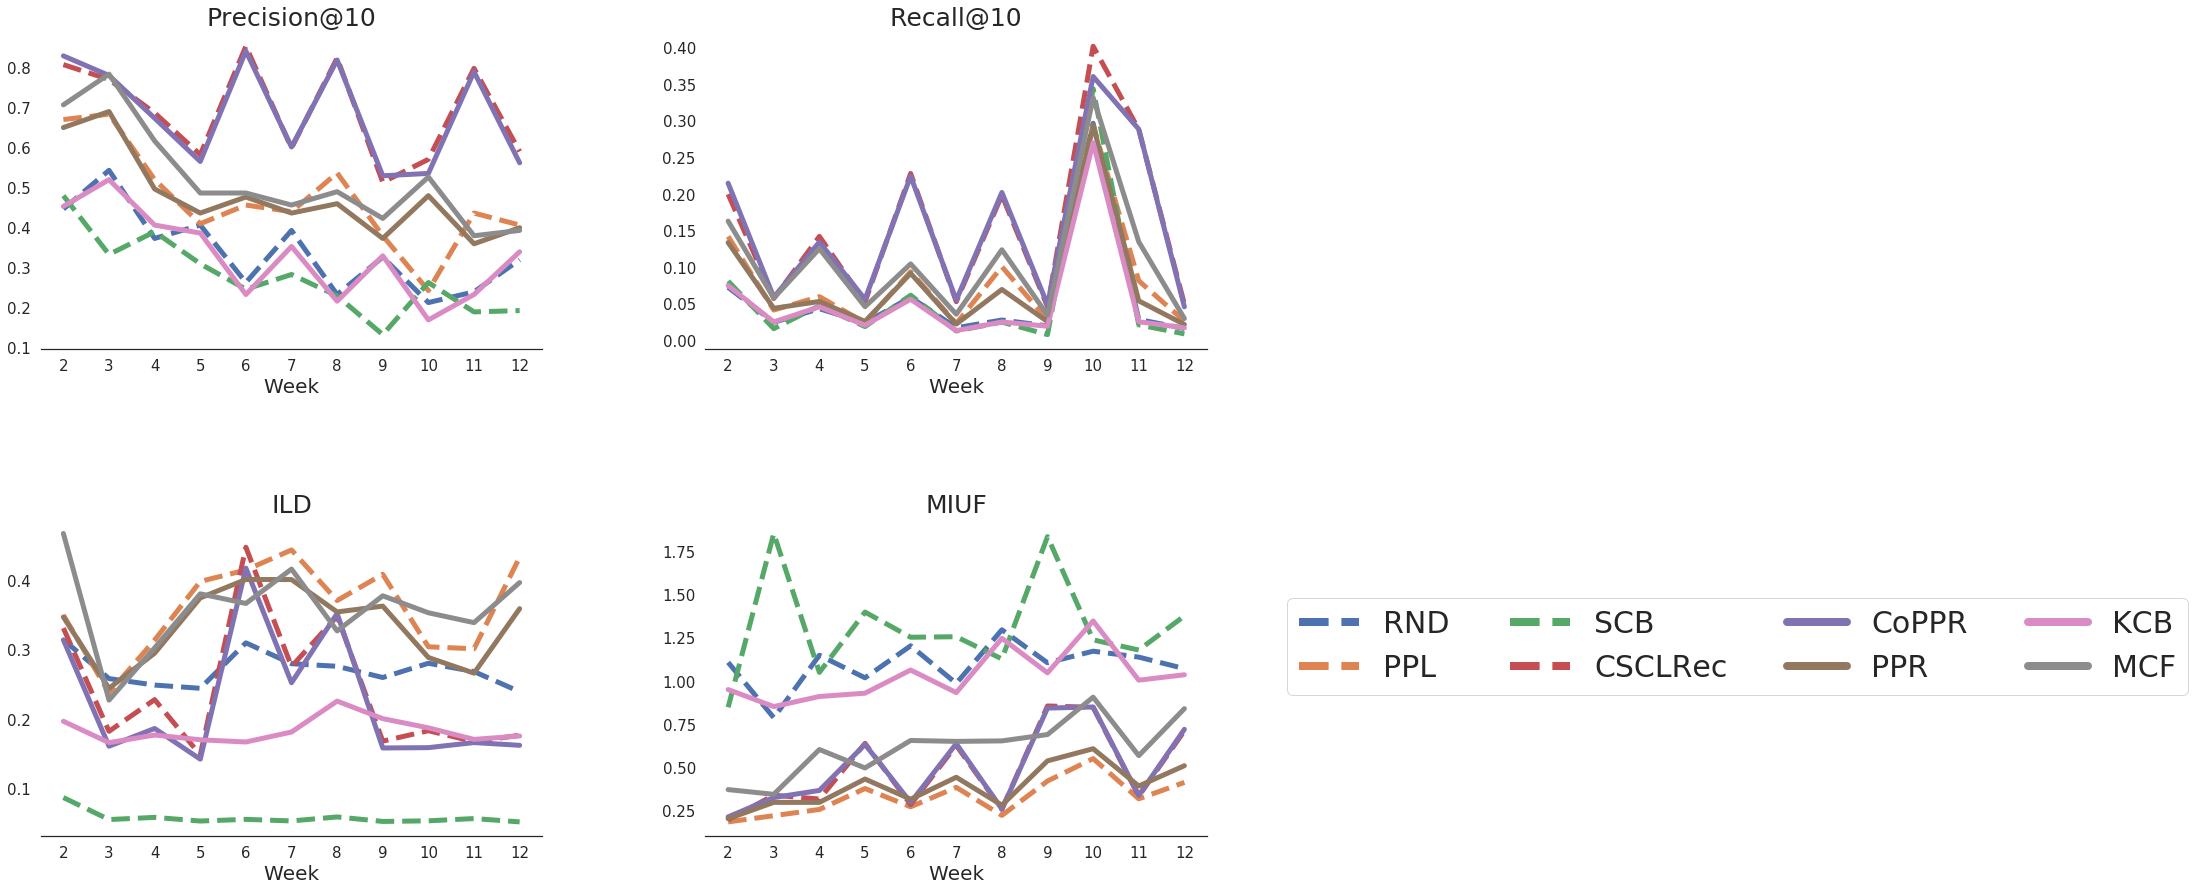

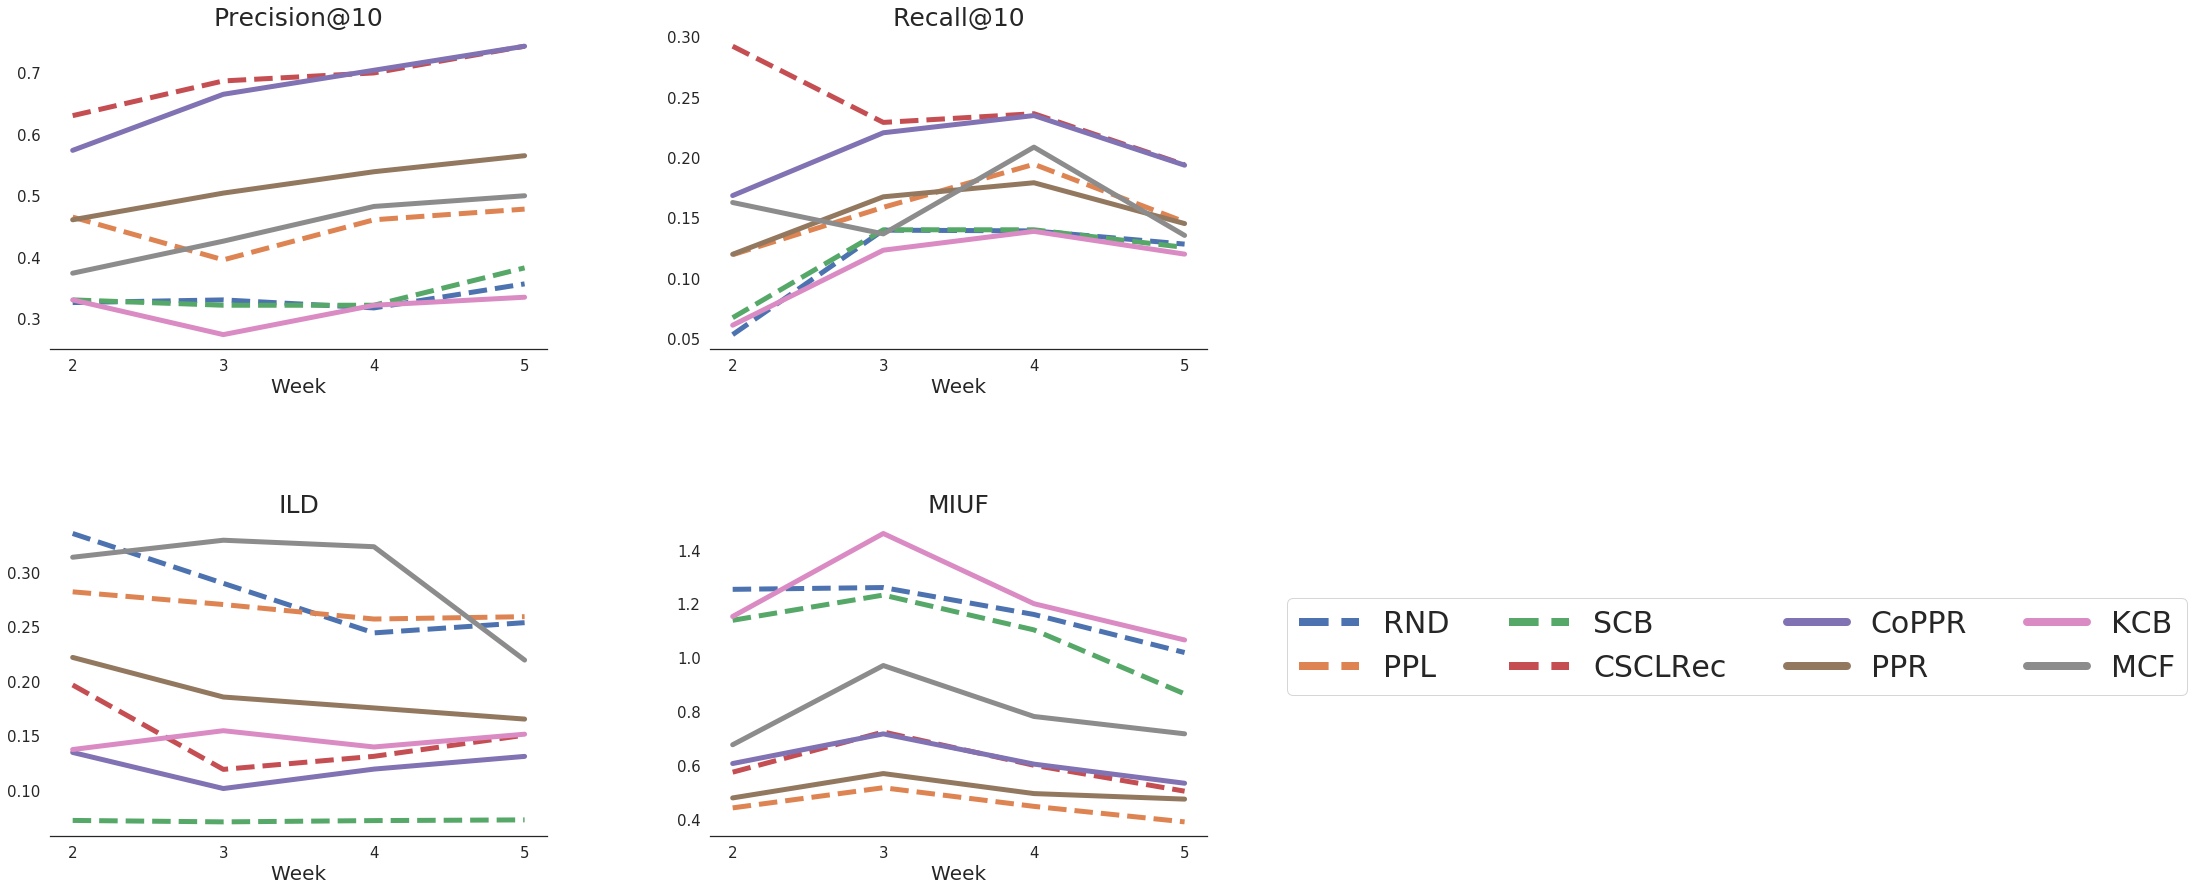

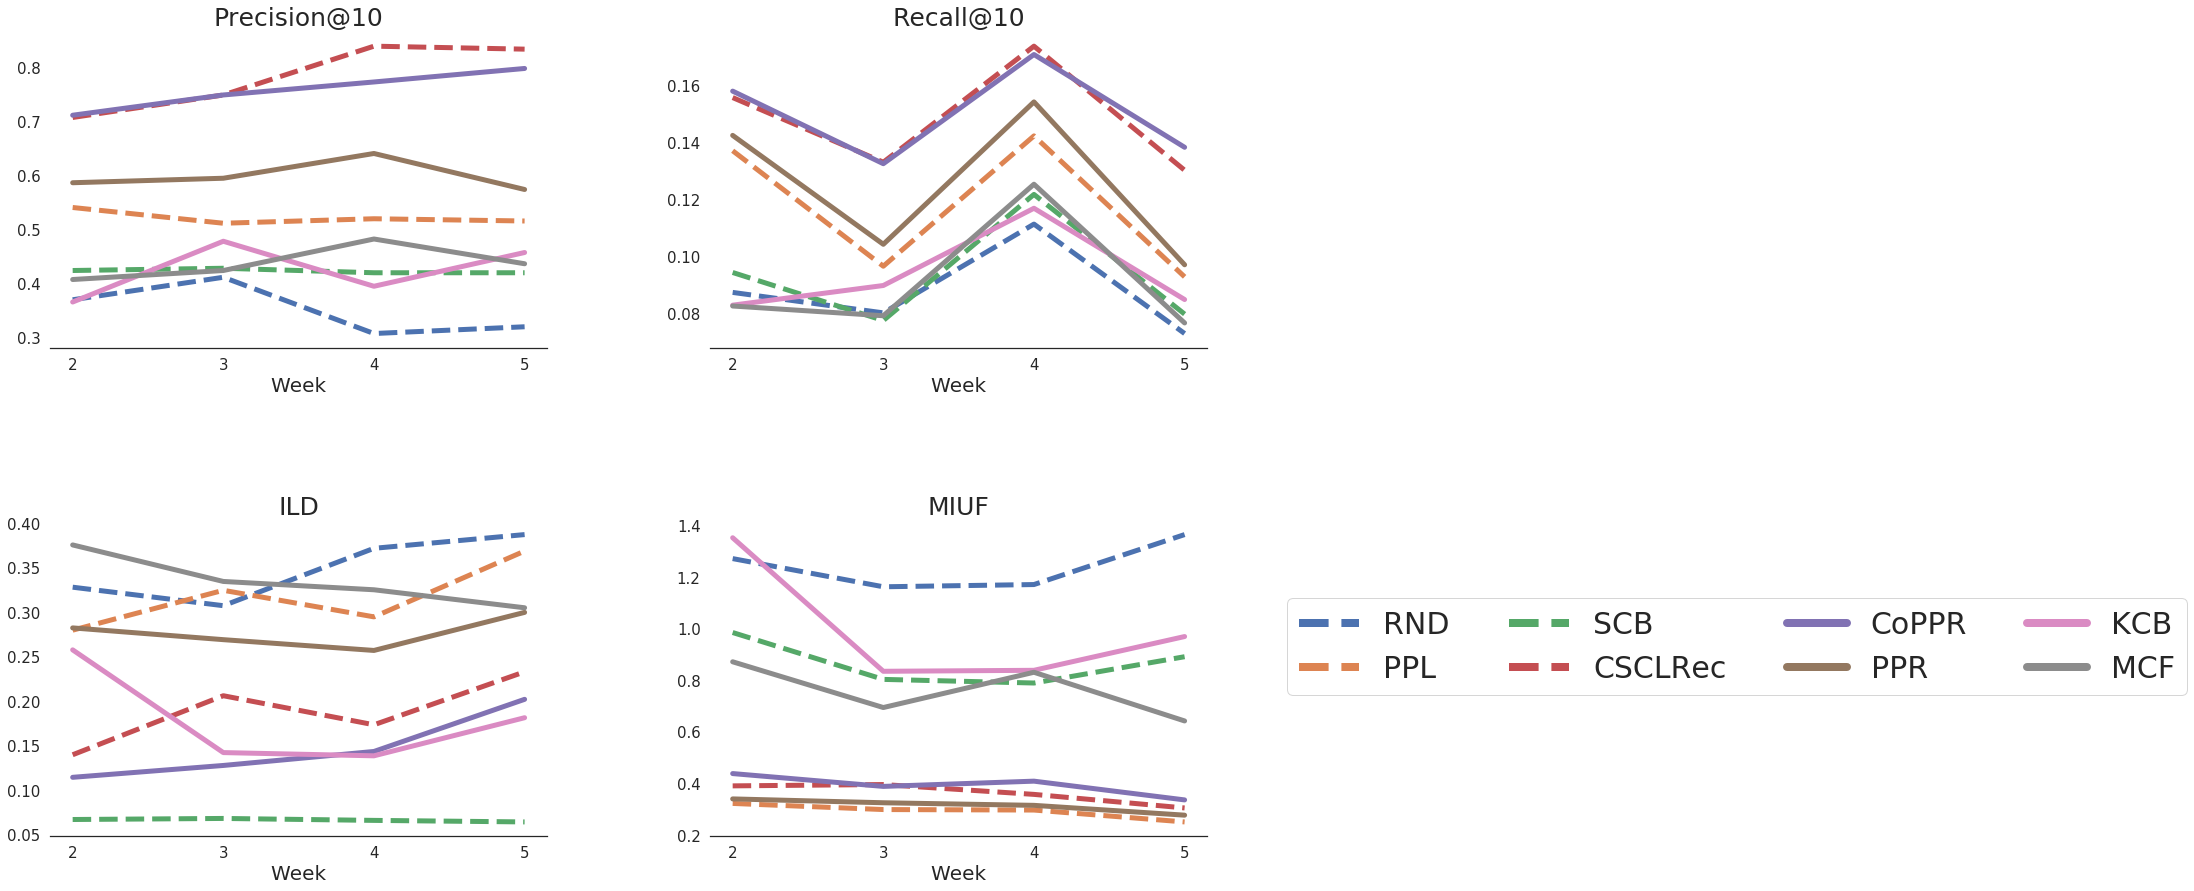

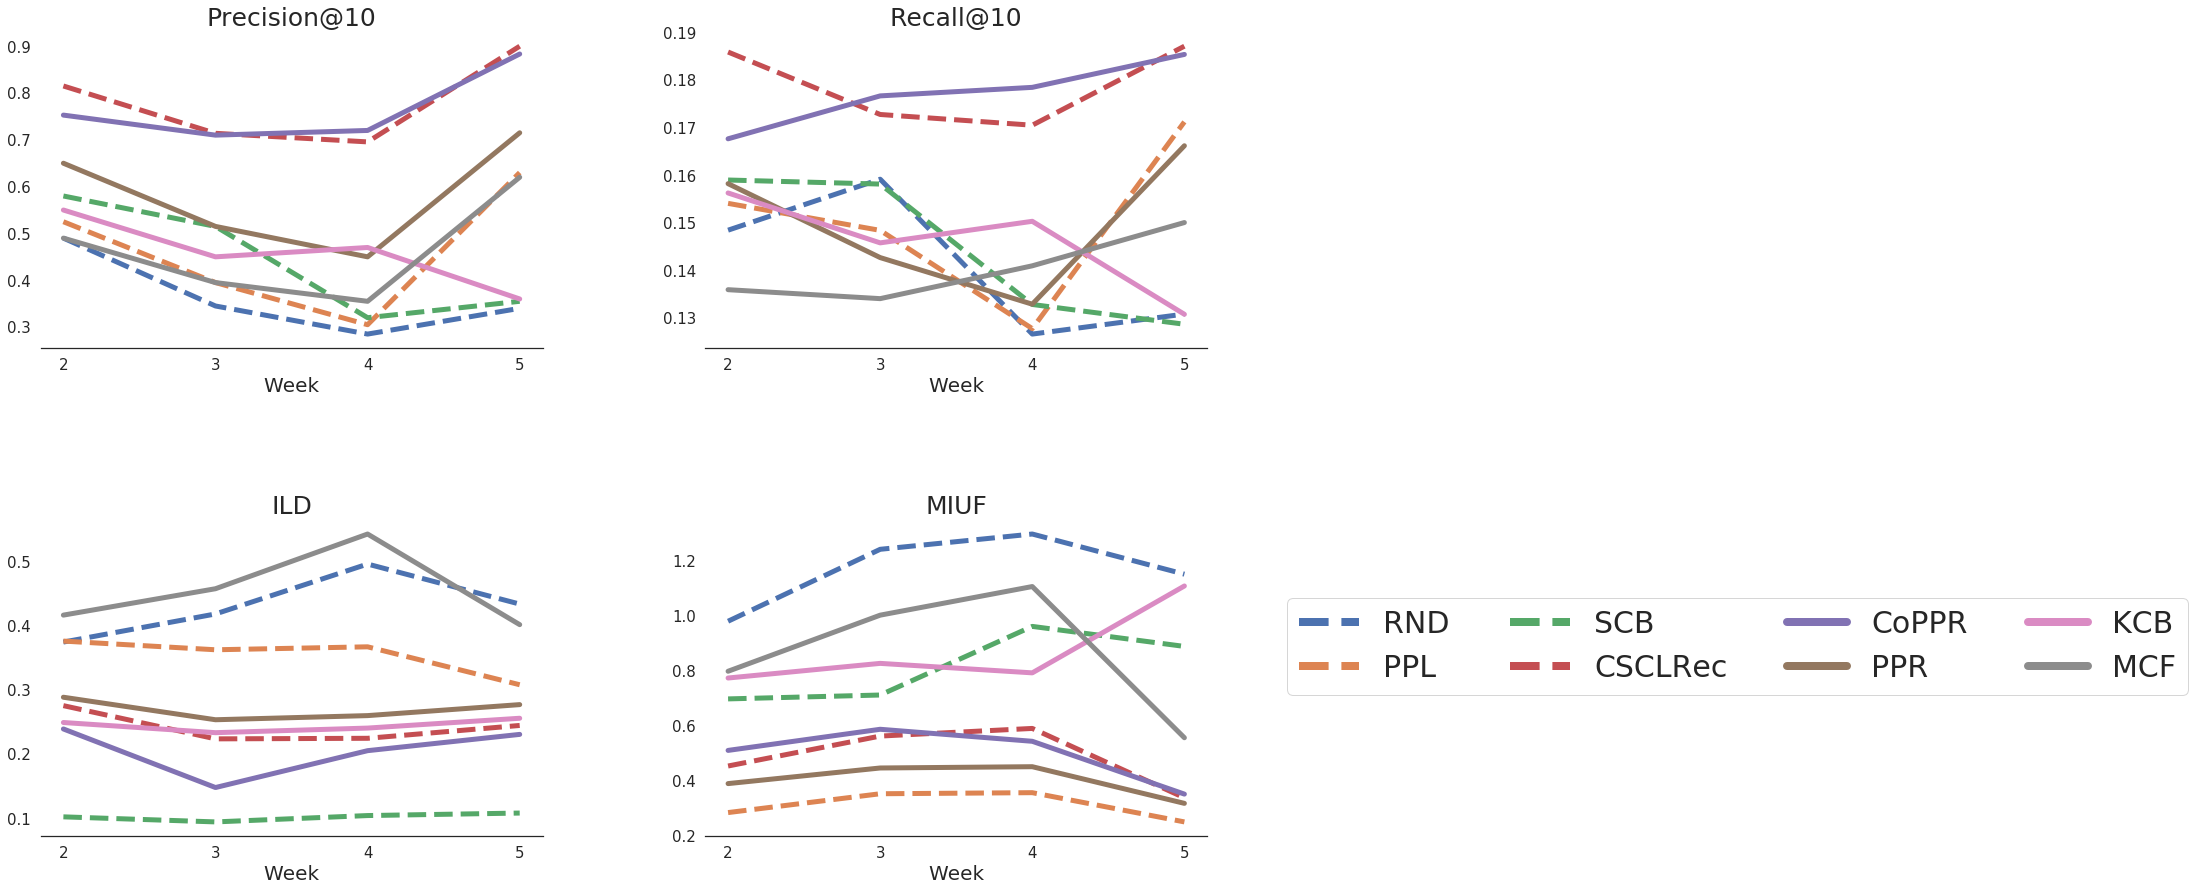

In [10]:
for dbnum in dbnums:
    plot_per_course(dbnum_lookup[dbnum], df_res)

In [11]:
df_res['course_type'] = df_res['course'].apply(lambda x: 'long' if x in ['LA','LB','LC'] else 'short')

In [12]:
# Note: here are only for course SA
for typ in ['long','short']:
    df_res_c = df_res.loc[df_res.course_type==typ,['miuf','p@10','r@10','ild','max possible recall','method']]
    print(df_res_c.groupby('method').mean().round(3))
    print(df_res_c.groupby('method').std().round(3))

          miuf   p@10   r@10    ild  max possible recall
method                                                  
CSCLRec  0.612  0.729  0.219  0.274                0.351
CoPPR    0.638  0.718  0.221  0.222                0.351
KCB      1.053  0.289  0.150  0.221                0.351
MCF      0.837  0.484  0.180  0.449                0.351
PPL      0.420  0.407  0.177  0.417                0.351
PPR      0.466  0.537  0.178  0.390                0.351
RND      1.174  0.307  0.157  0.406                0.351
SCB      1.216  0.294  0.158  0.075                0.351
          miuf   p@10   r@10    ild  max possible recall
method                                                  
CSCLRec  0.360  0.319  0.305  0.125                0.343
CoPPR    0.380  0.324  0.304  0.110                0.343
KCB      0.490  0.359  0.315  0.105                0.343
MCF      0.532  0.391  0.313  0.192                0.343
PPL      0.243  0.407  0.310  0.164                0.343
PPR      0.251  0.408  0.310  0